# Data Cleaning

## "Housekeeping"

List all the Python packages used with their respective version.

In [1]:
% load_ext watermark
% watermark -d -t -v -z -p numpy,pandas

2018-08-29 17:09:28 CEST

CPython 3.6.5
IPython 6.5.0

numpy 1.15.1
pandas 0.23.4


Import all the third-party (scientific) libraries needed.

In [2]:
import missingno as msno
import numpy as np
import pandas as pd

from tabulate import tabulate

The *utils.py* module defines helper dictionaries and lists that help with parsing the data types correctly, look up column descriptions, and refer to groups of data columns.

**Note:** the suffix \_*COLUMNS* indicates a dictionary with all meta information on the provided data file and \_*VARIABLES* a list with only the column names (i.e., the keys of the respective \_*COLUMNS* dictionary).

In [3]:
from utils import (
    ALL_COLUMNS,
    ALL_VARIABLES,
    CONTINUOUS_COLUMNS,
    CONTINUOUS_VARIABLES,
    DISCRETE_COLUMNS,
    DISCRETE_VARIABLES,
    INDEX_COLUMNS,
    LABEL_COLUMNS,  # groups nominal and ordinal
    LABEL_TYPES,
    NOMINAL_COLUMNS,
    NOMINAL_VARIABLES,
    NUMERIC_VARIABLES,  # groups continuous and discrete
    ORDINAL_COLUMNS,
    ORDINAL_VARIABLES,
    correct_column_names,
    update_column_descriptions,
)

In [4]:
# Allow cells to be run with a "%%black"
# prefix to make the code look beautiful.
% load_ext blackcellmagic

In [5]:
% matplotlib inline

In [6]:
# Show all data columns.
pd.set_option("display.max_columns", 100)

## Load the Data

The original data are available for [download](https://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls) and a detailed description of the data types for each column can be found [here](https://www.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt). These meta data go into the `dtype` argument of the `read_excel` function below to parse the data correctly. There are four different generic data types defined that are casted as follows:

- continuous -> np.float64
- discrete -> actually np.int64 but np.float64 because of missing values
- nominal -> object (str)
- ordinal -> object (str), the order can be looked up in the above mentioned *ALL_COLUMNS* dictionary

**Note 1:** the data come with a lot of "NA" text strings that do **not** indicate missing data but, for example, the absence of a basement or a parking lot (see the linked data description).

**Note 2:** the mappings from column names to data types are encoded in the "utils.py" module that defines the aforementioned helper dictionaries / lists.

**Note 3:** the Excel file with all the data is either loaded from the local dictionary (= "cache") or obtained fresh from the source.

In [7]:
# To avoid redundancy.
kwargs = {
    "dtype": {  # Ensure each column is parsed as the correct data type.
        column: (  # This creates a mapping from column name to data type.
            object if mapping_info["type"] in LABEL_TYPES else np.float64
        )
        for (column, mapping_info) in ALL_COLUMNS.items()
    },
    "na_values": "",  # By default, pandas treats NA strings as missing,
    "keep_default_na": False,  # which is not the correct meaning here.
}

try:
    df = pd.read_excel("data_raw.xls", **kwargs)
except FileNotFoundError:
    df = pd.read_excel(
        "https://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls", **kwargs
    )
    # Cache the obtained file.
    df.to_excel("data_raw.xls")

In [8]:
# Some columns names differ between the Excel file and
# the data description file. Correct that with the values
# in the Excel file.
correct_column_names(df.columns)
# Use a compound index and keep both
# identifying columns in the DataFrame.
df = df.set_index(INDEX_COLUMNS)
# Put the provided columns into the same
# order as in the encoded description file.
# Note that the target variable "SalePrice"
# is not in the description file.
df = df[ALL_VARIABLES + ["SalePrice"]]

## Spelling Mistakes & Data Types

Some textual values appear differently in the provided data file as compared to the specification. These inconsistencies are manually repaired.

In [9]:
# Repair spelling and whitespace mistakes.
df["Bldg Type"] = df["Bldg Type"].replace(to_replace="2fmCon", value="2FmCon")
df["Bldg Type"] = df["Bldg Type"].replace(to_replace="Duplex", value="Duplx")
df["Bldg Type"] = df["Bldg Type"].replace(to_replace="Twnhs", value="TwnhsI")
df["Exterior 2nd"] = df["Exterior 2nd"].replace(to_replace="Brk Cmn", value="BrkComm")
df["Exterior 2nd"] = df["Exterior 2nd"].replace(to_replace="CmentBd", value="CemntBd")
df["Exterior 2nd"] = df["Exterior 2nd"].replace(to_replace="Wd Shng", value="WdShing")
df["MS Zoning"] = df["MS Zoning"].replace(to_replace="A (agr)", value="A")
df["MS Zoning"] = df["MS Zoning"].replace(to_replace="C (all)", value="C")
df["MS Zoning"] = df["MS Zoning"].replace(to_replace="I (all)", value="I")
df["Neighborhood"] = df["Neighborhood"].replace(to_replace="NAmes", value="Names")
df["Sale Type"] = df["Sale Type"].replace(to_replace="WD ", value="WD")

In [10]:
# Ensure that the remaining textual values in the data file are a subset
# of the values allowed in the specification.
for column, mapping_info in LABEL_COLUMNS.items():
    # Note that .unique() returns a numpy array with integer dtype in cases
    # where the provided data can be casted as such (e.g., "Overall Qual" column).
    values_in_data = set(str(x) for x in df[column].unique() if x is not np.NaN)
    values_in_description = set(mapping_info["lookups"].keys())
    assert values_in_data <= values_in_description

Interestingly, all numeric columns (i.e. also "continuous" variables) come with only integer values.

In [11]:
# Show that all "continuous" variables come as integers.
for column in NUMERIC_VARIABLES + ["SalePrice"]:
    not_null = df[column].notnull()
    mask = (
        df.loc[not_null, column].astype(np.int64)
        != df.loc[not_null, column].astype(np.float64)
    )
    assert not mask.any()
# Cast discrete fields as integers where possible,
# i.e., all columns without missing values.
for column in DISCRETE_VARIABLES:
    try:
        df[column] = df[column].astype(np.int64)
    except ValueError:
        mask = df[column].notnull()
        df.loc[mask, column].astype(np.int64)

## Raw Data Overview

The overall shape of the data is a 2930 rows x 80 columns matrix.

In [12]:
df.shape

(2930, 80)

### Continuous Variables

The continuous columns are truly continuous in the sense that each column has at least 14 unique value realizations.

In [13]:
for column in CONTINUOUS_VARIABLES:
    mask = df[column].notnull()
    num_realizations = len(list(x for x in df.loc[mask, column].unique()))
    assert num_realizations > 13

A brief description of the variables:

In [14]:
table = ((key, value["description"]) for (key, value) in CONTINUOUS_COLUMNS.items())
print(tabulate(sorted(table), tablefmt="plain"))

1st Flr SF       First Floor square feet
2nd Flr SF       Second floor square feet
3Ssn Porch       Three season porch area in square feet
Bsmt Unf SF      Unfinished square feet of basement area
BsmtFin SF 1     Type 1 finished square feet
BsmtFin SF 2     Type 2 finished square feet
Enclosed Porch   Enclosed porch area in square feet
Garage Area      Size of garage in square feet
Gr Liv Area      Above grade (ground) living area square feet
Lot Area         Lot size in square feet
Lot Frontage     Linear feet of street connected to property
Low Qual Fin SF  Low quality finished square feet (all floors)
Mas Vnr Area     Masonry veneer area in square feet
Misc Val         $Value of miscellaneous feature
Open Porch SF    Open porch area in square feet
Pool Area        Pool area in square feet
Screen Porch     Screen porch area in square feet
Total Bsmt SF    Total square feet of basement area
Wood Deck SF     Wood deck area in square feet


In [15]:
df[CONTINUOUS_VARIABLES].head()

,,1st Flr SF,2nd Flr SF,3Ssn Porch,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,Enclosed Porch,Garage Area,Gr Liv Area,Lot Area,Lot Frontage,Low Qual Fin SF,Mas Vnr Area,Misc Val,Open Porch SF,Pool Area,Screen Porch,Total Bsmt SF,Wood Deck SF
Order,PID,,,,,,,,,,,,,,,,,,,
1,526301100,1656.0,0.0,0,441.0,639.0,0.0,0.0,528.0,1656.0,31770.0,141.0,0.0,112.0,0.0,62.0,0.0,0.0,1080.0,210.0
2,526350040,896.0,0.0,0,270.0,468.0,144.0,0.0,730.0,896.0,11622.0,80.0,0.0,0.0,0.0,0.0,0.0,120.0,882.0,140.0
3,526351010,1329.0,0.0,0,406.0,923.0,0.0,0.0,312.0,1329.0,14267.0,81.0,0.0,108.0,12500.0,36.0,0.0,0.0,1329.0,393.0
4,526353030,2110.0,0.0,0,1045.0,1065.0,0.0,0.0,522.0,2110.0,11160.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,2110.0,0.0
5,527105010,928.0,701.0,0,137.0,791.0,0.0,0.0,482.0,1629.0,13830.0,74.0,0.0,0.0,0.0,34.0,0.0,0.0,928.0,212.0


Except for the column *Lot Frontage* the columns with missing data only have a couple of missing values (i.e., < 1% of all the rows).

In [16]:
df[CONTINUOUS_VARIABLES].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2930 entries, (1, 526301100) to (2930, 924151050)
Data columns (total 19 columns):
1st Flr SF         2930 non-null float64
2nd Flr SF         2930 non-null float64
3Ssn Porch         2930 non-null int64
Bsmt Unf SF        2929 non-null float64
BsmtFin SF 1       2929 non-null float64
BsmtFin SF 2       2929 non-null float64
Enclosed Porch     2930 non-null float64
Garage Area        2929 non-null float64
Gr Liv Area        2930 non-null float64
Lot Area           2930 non-null float64
Lot Frontage       2440 non-null float64
Low Qual Fin SF    2930 non-null float64
Mas Vnr Area       2907 non-null float64
Misc Val           2930 non-null float64
Open Porch SF      2930 non-null float64
Pool Area          2930 non-null float64
Screen Porch       2930 non-null float64
Total Bsmt SF      2929 non-null float64
Wood Deck SF       2930 non-null float64
dtypes: float64(18), int64(1)
memory usage: 572.3 KB


In [17]:
# The columns with a lot of missing
# values will be treated seperately below.
missing_a_lot = ["Lot Frontage"]

### Discrete Variables

The discrete columns have between 2 and 15 unique realizations each if year numbers are excluded from the analysis.

In [18]:
for column in DISCRETE_VARIABLES:
    mask = df[column].notnull()
    num_realizations = len(list(x for x in df.loc[mask, column].unique()))
    if column not in ("Year Built", "Year Remod/Add", "Garage Yr Blt"):
        assert num_realizations < 15
    assert num_realizations > 2

A brief description of the variables:

In [19]:
table = ((key, value["description"]) for (key, value) in DISCRETE_COLUMNS.items())
print(tabulate(sorted(table), tablefmt="plain"))

Bedroom AbvGr   Bedrooms above grade (does NOT include basement bedrooms)
Bsmt Full Bath  Basement full bathrooms
Bsmt Half Bath  Basement half bathrooms
Fireplaces      Number of fireplaces
Full Bath       Full bathrooms above grade
Garage Cars     Size of garage in car capacity
Garage Yr Blt   Year garage was built
Half Bath       Half baths above grade
Kitchen AbvGr   Kitchens above grade
Mo Sold         Month Sold (MM)
TotRms AbvGrd   Total rooms above grade (does not include bathrooms)
Year Built      Original construction date
Year Remod/Add  Remodel date (same as construction date if no remodeling or additions)
Yr Sold         Year Sold (YYYY)


**Note:** columns with missing values are implicitly casted to a *float64* type an the *int64* type has no concept of a NaN (="Not a number") value.

In [20]:
df[DISCRETE_VARIABLES].head()

,,Bedroom AbvGr,Bsmt Full Bath,Bsmt Half Bath,Fireplaces,Full Bath,Garage Cars,Garage Yr Blt,Half Bath,Kitchen AbvGr,Mo Sold,TotRms AbvGrd,Year Built,Year Remod/Add,Yr Sold
Order,PID,,,,,,,,,,,,,,
1,526301100,3,1.0,0.0,2,1,2.0,1960.0,0,1,5,7,1960,1960,2010
2,526350040,2,0.0,0.0,0,1,1.0,1961.0,0,1,6,5,1961,1961,2010
3,526351010,3,0.0,0.0,0,1,1.0,1958.0,1,1,6,6,1958,1958,2010
4,526353030,3,1.0,0.0,2,2,2.0,1968.0,1,1,4,8,1968,1968,2010
5,527105010,3,0.0,0.0,1,2,2.0,1997.0,1,1,3,6,1997,1998,2010


Except for the *Garage Yr Blt* column no variable has a significant number of missing values (i.e., > 1% of all rows).

In [21]:
df[DISCRETE_VARIABLES].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2930 entries, (1, 526301100) to (2930, 924151050)
Data columns (total 14 columns):
Bedroom AbvGr     2930 non-null int64
Bsmt Full Bath    2928 non-null float64
Bsmt Half Bath    2928 non-null float64
Fireplaces        2930 non-null int64
Full Bath         2930 non-null int64
Garage Cars       2929 non-null float64
Garage Yr Blt     2771 non-null float64
Half Bath         2930 non-null int64
Kitchen AbvGr     2930 non-null int64
Mo Sold           2930 non-null int64
TotRms AbvGrd     2930 non-null int64
Year Built        2930 non-null int64
Year Remod/Add    2930 non-null int64
Yr Sold           2930 non-null int64
dtypes: float64(4), int64(10)
memory usage: 457.8 KB


In [22]:
missing_a_lot.append("Garage Yr Blt")

### Nominal Variables

Except for the total of 28 neighborhoods, the nominal columns come with anywhere between 1 and 18 different labels each.

In [23]:
for column in NOMINAL_VARIABLES:
    mask = df[column].notnull()
    num_realizations = len(list(x for x in df.loc[mask, column].unique()))
    if column not in ("Neighborhood"):
        assert num_realizations < 18
    assert num_realizations > 1

A brief description of the variables:

In [24]:
table = ((key, value["description"]) for (key, value) in NOMINAL_COLUMNS.items())
print(tabulate(sorted(table), tablefmt="plain"))

Alley           Type of alley access to property
Bldg Type       Type of dwelling
Central Air     Central air conditioning
Condition 1     Proximity to various conditions
Condition 2     Proximity to various conditions (if more than one is present)
Exterior 1st    Exterior covering on house
Exterior 2nd    Exterior covering on house (if more than one material)
Foundation      Type of foundation
Garage Type     Garage location
Heating         Type of heating
House Style     Style of dwelling
Land Contour    Flatness of the property
Lot Config      Lot configuration
MS SubClass     Identifies the type of dwelling involved in the sale.
MS Zoning       Identifies the general zoning classification of the sale.
Mas Vnr Type    Masonry veneer type
Misc Feature    Miscellaneous feature not covered in other categories
Neighborhood    Physical locations within Ames city limits (map available)
Roof Matl       Roof material
Roof Style      Type of roof
Sale Condition  Condition of sale
Sale Type  

In [25]:
df[NOMINAL_VARIABLES].head(10)

,,Alley,Bldg Type,Central Air,Condition 1,Condition 2,Exterior 1st,Exterior 2nd,Foundation,Garage Type,Heating,House Style,Land Contour,Lot Config,MS SubClass,MS Zoning,Mas Vnr Type,Misc Feature,Neighborhood,Roof Matl,Roof Style,Sale Condition,Sale Type,Street
Order,PID,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,NA,1Fam,Y,Norm,Norm,BrkFace,Plywood,CBlock,Attchd,GasA,1Story,Lvl,Corner,020,RL,Stone,NA,Names,CompShg,Hip,Normal,WD,Pave
2,526350040,NA,1Fam,Y,Feedr,Norm,VinylSd,VinylSd,CBlock,Attchd,GasA,1Story,Lvl,Inside,020,RH,None,NA,Names,CompShg,Gable,Normal,WD,Pave
3,526351010,NA,1Fam,Y,Norm,Norm,Wd Sdng,Wd Sdng,CBlock,Attchd,GasA,1Story,Lvl,Corner,020,RL,BrkFace,Gar2,Names,CompShg,Hip,Normal,WD,Pave
4,526353030,NA,1Fam,Y,Norm,Norm,BrkFace,BrkFace,CBlock,Attchd,GasA,1Story,Lvl,Corner,020,RL,None,NA,Names,CompShg,Hip,Normal,WD,Pave
5,527105010,NA,1Fam,Y,Norm,Norm,VinylSd,VinylSd,PConc,Attchd,GasA,2Story,Lvl,Inside,060,RL,None,NA,Gilbert,CompShg,Gable,Normal,WD,Pave
6,527105030,NA,1Fam,Y,Norm,Norm,VinylSd,VinylSd,PConc,Attchd,GasA,2Story,Lvl,Inside,060,RL,BrkFace,NA,Gilbert,CompShg,Gable,Normal,WD,Pave
7,527127150,NA,TwnhsE,Y,Norm,Norm,CemntBd,CemntBd,PConc,Attchd,GasA,1Story,Lvl,Inside,120,RL,None,NA,StoneBr,CompShg,Gable,Normal,WD,Pave
8,527145080,NA,TwnhsE,Y,Norm,Norm,HdBoard,HdBoard,PConc,Attchd,GasA,1Story,HLS,Inside,120,RL,None,NA,StoneBr,CompShg,Gable,Normal,WD,Pave
9,527146030,NA,TwnhsE,Y,Norm,Norm,CemntBd,CemntBd,PConc,Attchd,GasA,1Story,Lvl,Inside,120,RL,None,NA,StoneBr,CompShg,Gable,Normal,WD,Pave


For the nominal variables there is only a neglectable number of missing values.

In [26]:
df[NOMINAL_VARIABLES].info(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2930 entries, (1, 526301100) to (2930, 924151050)
Data columns (total 23 columns):
Alley             2930 non-null object
Bldg Type         2930 non-null object
Central Air       2930 non-null object
Condition 1       2930 non-null object
Condition 2       2930 non-null object
Exterior 1st      2930 non-null object
Exterior 2nd      2930 non-null object
Foundation        2930 non-null object
Garage Type       2930 non-null object
Heating           2930 non-null object
House Style       2930 non-null object
Land Contour      2930 non-null object
Lot Config        2930 non-null object
MS SubClass       2930 non-null object
MS Zoning         2930 non-null object
Mas Vnr Type      2907 non-null object
Misc Feature      2930 non-null object
Neighborhood      2930 non-null object
Roof Matl         2930 non-null object
Roof Style        2930 non-null object
Sale Condition    2930 non-null object
Sale Type         2930 non-null object
Street   

### Ordinal Variables

The ordinal columns come with anywhere between 2 and 11 distinct labels each.

In [27]:
for column in ORDINAL_VARIABLES:
    mask = df[column].notnull()
    num_realizations = len(list(x for x in df.loc[mask, column].unique()))
    assert 2 < num_realizations < 11

A brief description of the variables:

In [28]:
table = ((key, value["description"]) for (key, value) in ORDINAL_COLUMNS.items())
print(tabulate(sorted(table), tablefmt="plain"))

Bsmt Cond       Evaluates the general condition of the basement
Bsmt Exposure   Refers to walkout or garden level walls
Bsmt Qual       Evaluates the height of the basement
BsmtFin Type 1  Rating of basement finished area
BsmtFin Type 2  Rating of basement finished area (if multiple types)
Electrical      Electrical system
Exter Cond      Evaluates the present condition of the material on the exterior
Exter Qual      Evaluates the quality of the material on the exterior
Fence           Fence quality
Fireplace Qu    Fireplace quality
Functional      Home functionality (Assume typical unless deductions are warranted)
Garage Cond     Garage condition
Garage Finish   Interior finish of the garage
Garage Qual     Garage quality
Heating QC      Heating quality and condition
Kitchen Qual    Kitchen quality
Land Slope      Slope of property
Lot Shape       General shape of property
Overall Cond    Rates the overall condition of the house
Overall Qual    Rates the overall material and finish of

In [29]:
df[ORDINAL_VARIABLES].head(10)

,,Bsmt Cond,Bsmt Exposure,Bsmt Qual,BsmtFin Type 1,BsmtFin Type 2,Electrical,Exter Cond,Exter Qual,Fence,Fireplace Qu,Functional,Garage Cond,Garage Finish,Garage Qual,Heating QC,Kitchen Qual,Land Slope,Lot Shape,Overall Cond,Overall Qual,Paved Drive,Pool QC,Utilities
Order,PID,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,Gd,Gd,TA,BLQ,Unf,SBrkr,TA,TA,NA,Gd,Typ,TA,Fin,TA,Fa,TA,Gtl,IR1,5,6,P,NA,AllPub
2,526350040,TA,No,TA,Rec,LwQ,SBrkr,TA,TA,MnPrv,NA,Typ,TA,Unf,TA,TA,TA,Gtl,Reg,6,5,Y,NA,AllPub
3,526351010,TA,No,TA,ALQ,Unf,SBrkr,TA,TA,NA,NA,Typ,TA,Unf,TA,TA,Gd,Gtl,IR1,6,6,Y,NA,AllPub
4,526353030,TA,No,TA,ALQ,Unf,SBrkr,TA,Gd,NA,TA,Typ,TA,Fin,TA,Ex,Ex,Gtl,Reg,5,7,Y,NA,AllPub
5,527105010,TA,No,Gd,GLQ,Unf,SBrkr,TA,TA,MnPrv,TA,Typ,TA,Fin,TA,Gd,TA,Gtl,IR1,5,5,Y,NA,AllPub
6,527105030,TA,No,TA,GLQ,Unf,SBrkr,TA,TA,NA,Gd,Typ,TA,Fin,TA,Ex,Gd,Gtl,IR1,6,6,Y,NA,AllPub
7,527127150,TA,Mn,Gd,GLQ,Unf,SBrkr,TA,Gd,NA,NA,Typ,TA,Fin,TA,Ex,Gd,Gtl,Reg,5,8,Y,NA,AllPub
8,527145080,TA,No,Gd,ALQ,Unf,SBrkr,TA,Gd,NA,NA,Typ,TA,RFn,TA,Ex,Gd,Gtl,IR1,5,8,Y,NA,AllPub
9,527146030,TA,No,Gd,GLQ,Unf,SBrkr,TA,Gd,NA,TA,Typ,TA,RFn,TA,Ex,Gd,Gtl,IR1,5,8,Y,NA,AllPub


For the ordinal variables there is only a neglectable number of missing values.

In [30]:
df[ORDINAL_VARIABLES].info(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2930 entries, (1, 526301100) to (2930, 924151050)
Data columns (total 23 columns):
Bsmt Cond         2929 non-null object
Bsmt Exposure     2926 non-null object
Bsmt Qual         2929 non-null object
BsmtFin Type 1    2929 non-null object
BsmtFin Type 2    2928 non-null object
Electrical        2929 non-null object
Exter Cond        2930 non-null object
Exter Qual        2930 non-null object
Fence             2930 non-null object
Fireplace Qu      2930 non-null object
Functional        2930 non-null object
Garage Cond       2929 non-null object
Garage Finish     2928 non-null object
Garage Qual       2929 non-null object
Heating QC        2930 non-null object
Kitchen Qual      2930 non-null object
Land Slope        2930 non-null object
Lot Shape         2930 non-null object
Overall Cond      2930 non-null object
Overall Qual      2930 non-null object
Paved Drive       2930 non-null object
Pool QC           2930 non-null object
Utilities

## Missing Data

### Visualizations

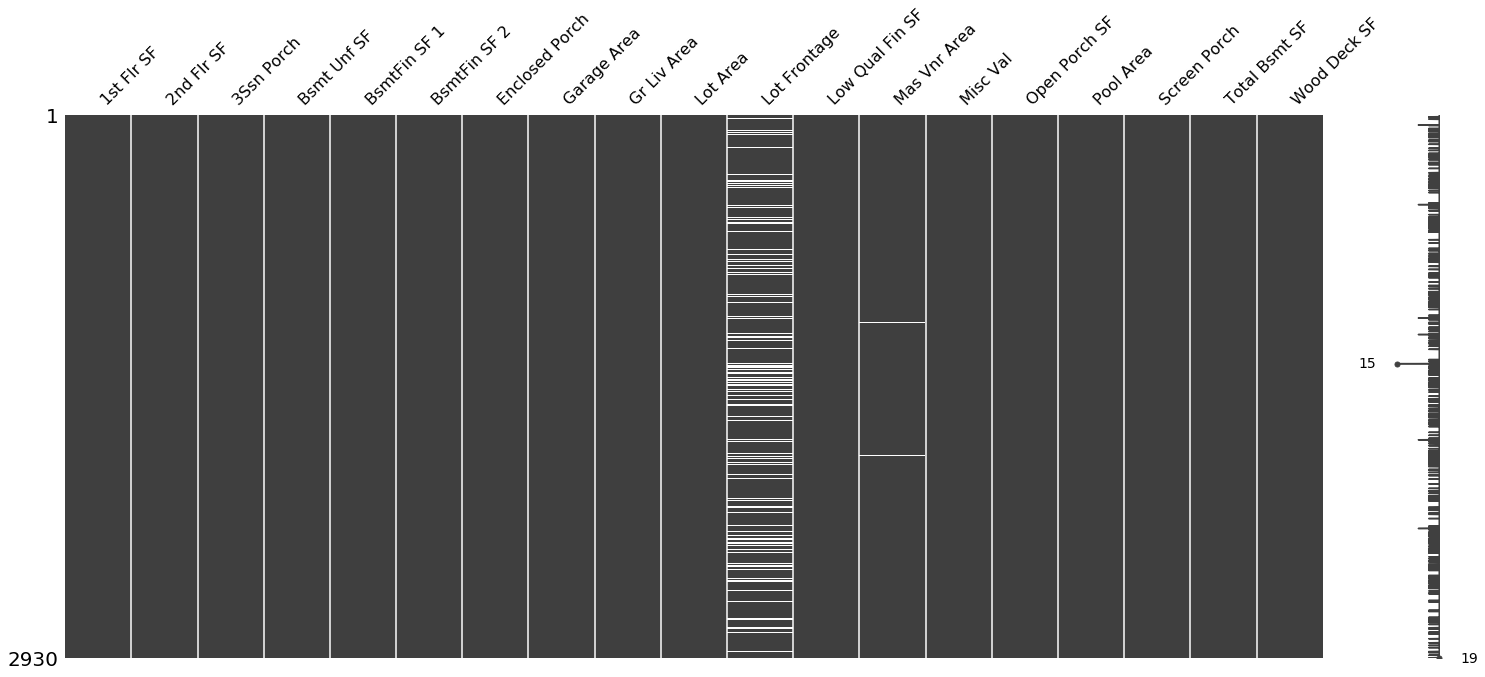

In [31]:
msno.matrix(df[CONTINUOUS_VARIABLES]);

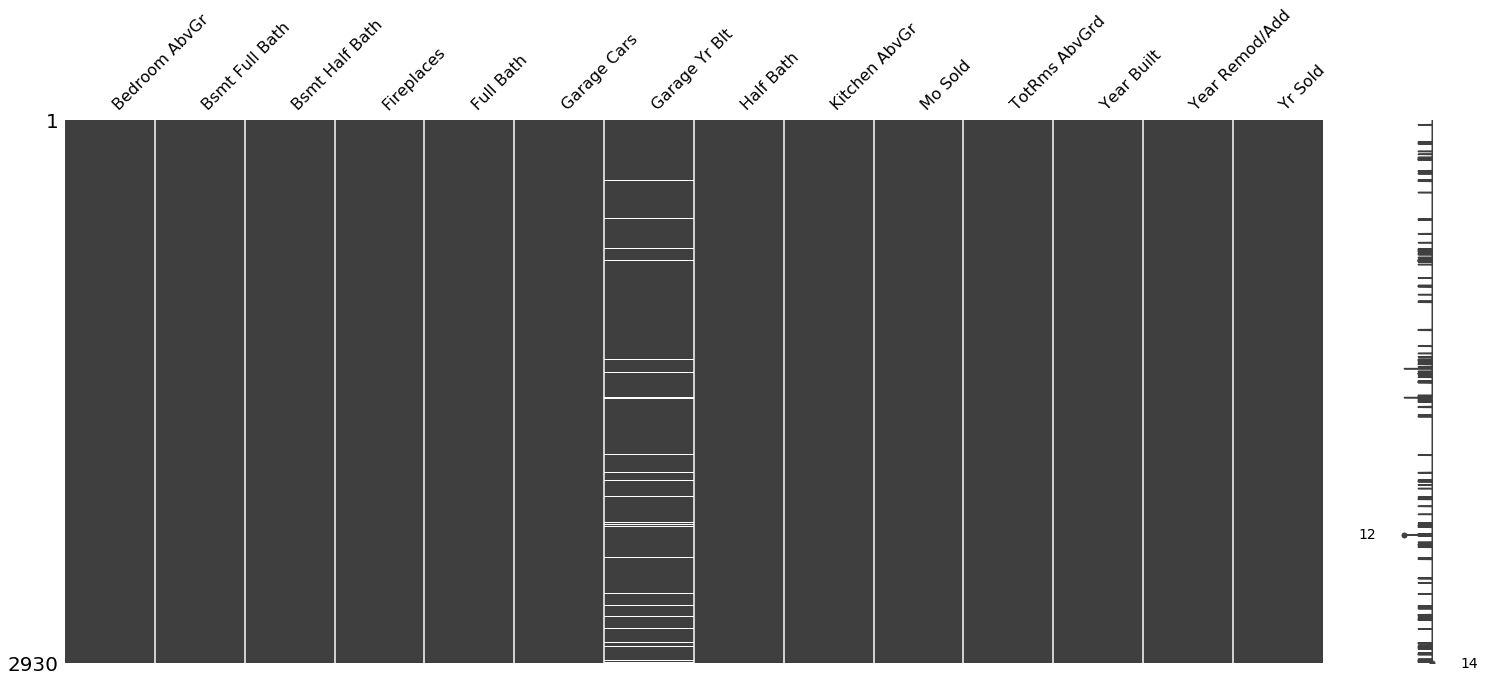

In [32]:
msno.matrix(df[DISCRETE_VARIABLES]);

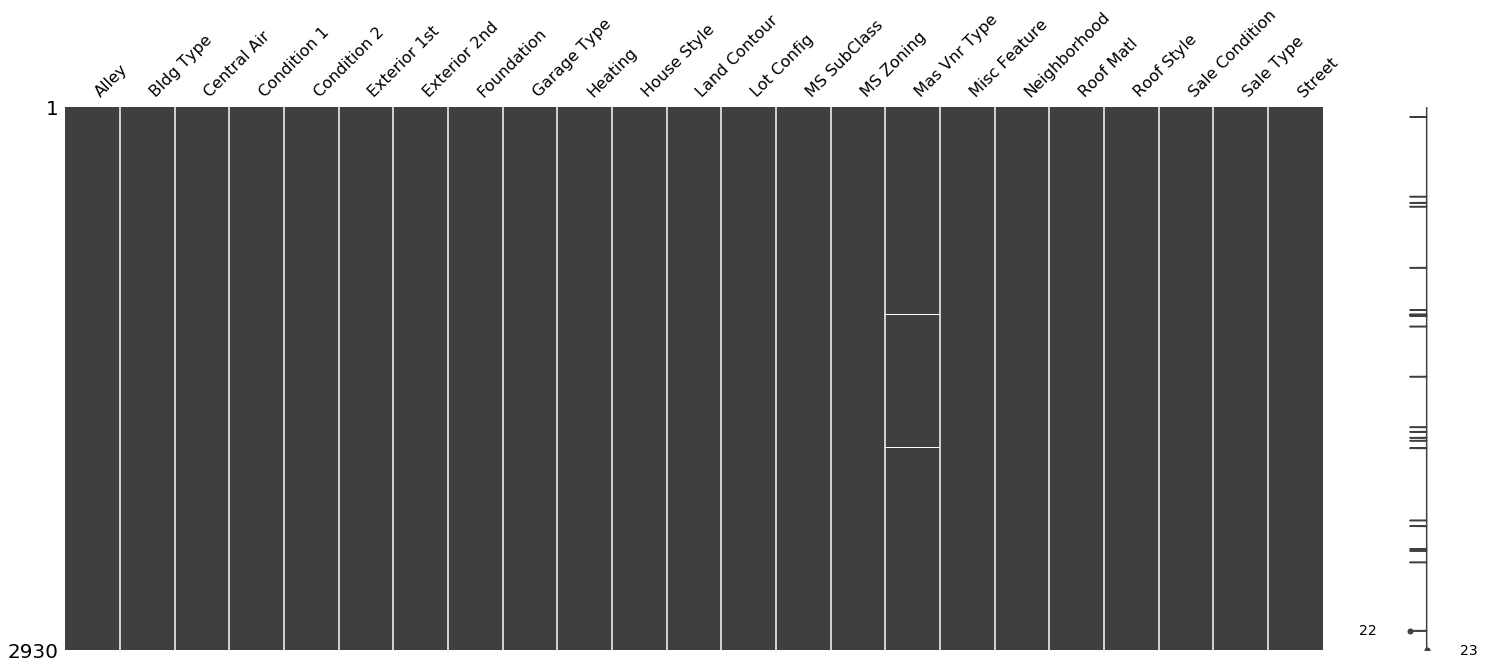

In [33]:
msno.matrix(df[NOMINAL_VARIABLES]);

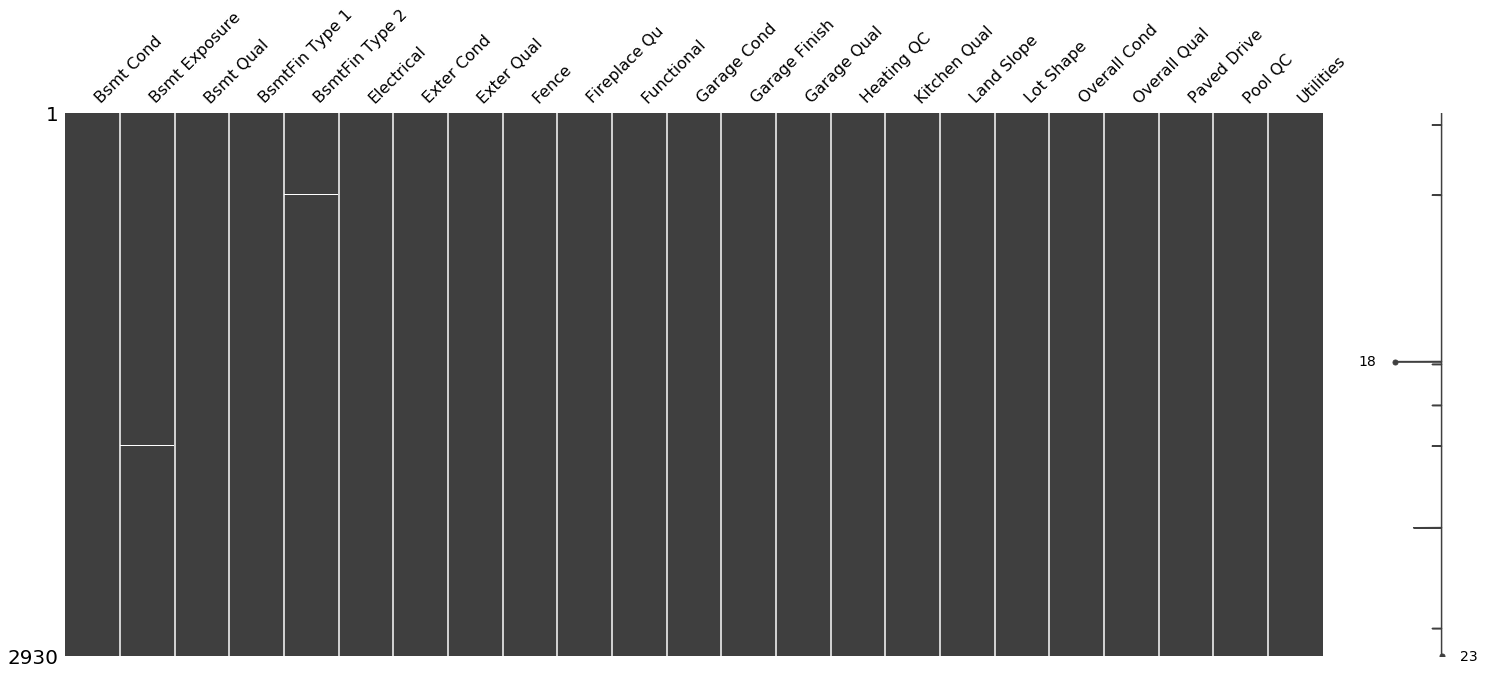

In [34]:
msno.matrix(df[ORDINAL_VARIABLES]);

### Cleansing

Since only about 1% of the overall number of observations exhibit variables with missing data (disregarding the columns *Lot Frontage* and *Garage Yr Blt*), the decision is made to discard these rows entirely to not have to deal with interpolating meaningful replacements for the missing values.

In [35]:
remaining_columns = sorted(set(ALL_VARIABLES) - set(missing_a_lot)) + ["SalePrice"]
mask = df[remaining_columns].isnull().any(axis=1)
assert (100 * mask.sum() / df.shape[0]) < 1.1  # percent
df = df[~mask]

The two columns with a lot of missing values regard the age of a house's optional garage and the length of the intersection with the street where the house is located. The first is assumed as not important for the house appraisal and the second is assumed to be captured in other variables (e.g. overall size of the house). Therefore, for sake of simplicity both columns are dropped from the DataFrame.

In [36]:
table = ((col, ALL_COLUMNS[col]["description"]) for col in sorted(missing_a_lot))
print(tabulate(table, tablefmt="plain"))

Garage Yr Blt  Year garage was built
Lot Frontage   Linear feet of street connected to property


In [37]:
df = df[remaining_columns]

In [38]:
# Remove the discarded columns from the helper dictionaries / lists.
update_column_descriptions(df.columns)
# Without any more missing data, cast all numeric
# columns as floats or integers respectively.
for column in CONTINUOUS_VARIABLES:
    df[column] = df[column].astype(np.float64)
for column in DISCRETE_VARIABLES:
    df[column] = df[column].astype(np.int64)

## Clean Data

The cleaned data comes as a 2898 rows x 78 columns matrix.

In [39]:
df.shape

(2898, 78)

In [40]:
df.head()

,,1st Flr SF,2nd Flr SF,3Ssn Porch,Alley,Bedroom AbvGr,Bldg Type,Bsmt Cond,Bsmt Exposure,Bsmt Full Bath,Bsmt Half Bath,Bsmt Qual,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,BsmtFin Type 1,BsmtFin Type 2,Central Air,Condition 1,Condition 2,Electrical,Enclosed Porch,Exter Cond,Exter Qual,Exterior 1st,Exterior 2nd,Fence,Fireplace Qu,Fireplaces,Foundation,Full Bath,Functional,Garage Area,Garage Cars,Garage Cond,Garage Finish,Garage Qual,Garage Type,Gr Liv Area,Half Bath,Heating,Heating QC,House Style,Kitchen AbvGr,Kitchen Qual,Land Contour,Land Slope,Lot Area,Lot Config,Lot Shape,Low Qual Fin SF,MS SubClass,MS Zoning,Mas Vnr Area,Mas Vnr Type,Misc Feature,Misc Val,Mo Sold,Neighborhood,Open Porch SF,Overall Cond,Overall Qual,Paved Drive,Pool Area,Pool QC,Roof Matl,Roof Style,Sale Condition,Sale Type,Screen Porch,Street,TotRms AbvGrd,Total Bsmt SF,Utilities,Wood Deck SF,Year Built,Year Remod/Add,Yr Sold,SalePrice
Order,PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,1656.0,0.0,0.0,NA,3,1Fam,Gd,Gd,1,0,TA,441.0,639.0,0.0,BLQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,TA,BrkFace,Plywood,NA,Gd,2,CBlock,1,Typ,528.0,2,TA,Fin,TA,Attchd,1656.0,0,GasA,Fa,1Story,1,TA,Lvl,Gtl,31770.0,Corner,IR1,0.0,020,RL,112.0,Stone,NA,0.0,5,Names,62.0,5,6,P,0.0,NA,CompShg,Hip,Normal,WD,0.0,Pave,7,1080.0,AllPub,210.0,1960,1960,2010,215000
2,526350040,896.0,0.0,0.0,NA,2,1Fam,TA,No,0,0,TA,270.0,468.0,144.0,Rec,LwQ,Y,Feedr,Norm,SBrkr,0.0,TA,TA,VinylSd,VinylSd,MnPrv,NA,0,CBlock,1,Typ,730.0,1,TA,Unf,TA,Attchd,896.0,0,GasA,TA,1Story,1,TA,Lvl,Gtl,11622.0,Inside,Reg,0.0,020,RH,0.0,None,NA,0.0,6,Names,0.0,6,5,Y,0.0,NA,CompShg,Gable,Normal,WD,120.0,Pave,5,882.0,AllPub,140.0,1961,1961,2010,105000
3,526351010,1329.0,0.0,0.0,NA,3,1Fam,TA,No,0,0,TA,406.0,923.0,0.0,ALQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,TA,Wd Sdng,Wd Sdng,NA,NA,0,CBlock,1,Typ,312.0,1,TA,Unf,TA,Attchd,1329.0,1,GasA,TA,1Story,1,Gd,Lvl,Gtl,14267.0,Corner,IR1,0.0,020,RL,108.0,BrkFace,Gar2,12500.0,6,Names,36.0,6,6,Y,0.0,NA,CompShg,Hip,Normal,WD,0.0,Pave,6,1329.0,AllPub,393.0,1958,1958,2010,172000
4,526353030,2110.0,0.0,0.0,NA,3,1Fam,TA,No,1,0,TA,1045.0,1065.0,0.0,ALQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,Gd,BrkFace,BrkFace,NA,TA,2,CBlock,2,Typ,522.0,2,TA,Fin,TA,Attchd,2110.0,1,GasA,Ex,1Story,1,Ex,Lvl,Gtl,11160.0,Corner,Reg,0.0,020,RL,0.0,None,NA,0.0,4,Names,0.0,5,7,Y,0.0,NA,CompShg,Hip,Normal,WD,0.0,Pave,8,2110.0,AllPub,0.0,1968,1968,2010,244000
5,527105010,928.0,701.0,0.0,NA,3,1Fam,TA,No,0,0,Gd,137.0,791.0,0.0,GLQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,TA,VinylSd,VinylSd,MnPrv,TA,1,PConc,2,Typ,482.0,2,TA,Fin,TA,Attchd,1629.0,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,13830.0,Inside,IR1,0.0,060,RL,0.0,None,NA,0.0,3,Gilbert,34.0,5,5,Y,0.0,NA,CompShg,Gable,Normal,WD,0.0,Pave,6,928.0,AllPub,212.0,1997,1998,2010,189900


In [41]:
df.to_csv("data_clean.csv")